# Overview
This is an example of how someone might generate and store models that can be compared for fairness. 

----
# Part 1 - Loading the Data <a class="anchor" id="part1"></a>


In [2]:
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    else:
        h, ms = divmod((datetime.now() - start_time).total_seconds(), 3600)
        m, s = divmod(ms, 60)
        print(f"Elapsed Time: {h} hours {m} minutes {round(s, 4)} seconds.")
        
start_time = timer()
timer(start_time)

Elapsed Time: 0.0 hours 0.0 minutes 0.0 seconds.


## Loading MIMIC III Data
As mentioned above, the MIMIC-III data download contains a folder of zipped_files. The tutorial code in the [Data Subset](#datasubset) section below will automatically unzip and format all necessary data for these experiments, saving the formatted data in the same MIMIC folder. Simply enter the correct path of the MIMIC folder in the following cell to enable this feature. Your path should end with the directory "MIMIC".

Example: path_to_mimic_data_folder = "~/data/MIMIC"

In [3]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

In [17]:
# output file for combined data and models
output_file = os.path.expanduser("~/data/fairness_and_bias/mimic_model_comparison/binary_classification.joblib")


## Data Subset <a id="datasubset"></a>
Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [4]:
df = helper.load_example_data(path_to_mimic_data_folder) 
df = df.loc[df['AGE'].ge(65),:]
helper.print_feature_table(df)
display(Markdown('---'))
display(df.head())


 This data subset has 22434 total observations and 648 input features 



,Raw Feature,Category Count (Encoded Features)
0,AGE,1
1,DIAGNOSIS,282
2,ETHNICITY,41
3,GENDER,1
4,INSURANCE,5
5,LANGUAGE,69
6,MARRIED,7
7,PROCEDURE,222
8,RELIGION,20


---

,ADMIT_ID,AGE,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,ETHNICITY_ASIAN - JAPANESE,ETHNICITY_ASIAN - KOREAN,ETHNICITY_ASIAN - OTHER,ETHNICITY_ASIAN - THAI,ETHNICITY_ASIAN - VIETNAMESE,ETHNICITY_BLACK/AFRICAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_BLACK/CAPE VERDEAN,ETHNICITY_BLACK/HAITIAN,ETHNICITY_CARIBBEAN ISLAND,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER),ETHNICITY_HISPANIC/LATINO - COLOMBIAN,ETHNICITY_HISPANIC/LATINO - CUBAN,ETHNICITY_HISPANIC/LATINO - DOMINICAN,ETHNICITY_HISPANIC/LATINO - GUATEMALAN,ETHNICITY_HISPANIC/LATINO - HONDURAN,ETHNICITY_HISPANIC/LATINO - MEXICAN,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_HISPANIC/LATINO - SALVADORAN,ETHNICITY_MIDDLE EASTERN,ETHNICITY_MULTI RACE ETHNICITY,ETHNICITY_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ETHNICITY_OTHER,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN,LANGUAGE_* BE,LANGUAGE_* FU,LANGUAGE_** T,LANGUAGE_**SH,LANGUAGE_**TO,LANGUAGE_*AMH,LANGUAGE_*ARA,LANGUAGE_*ARM,LANGUAGE_*BEN,LANGUAGE_*BOS,LANGUAGE_*BUL,LANGUAGE_*BUR,LANGUAGE_*CAN,LANGUAGE_*CDI,LANGUAGE_*CHI,LANGUAGE_*DEA,LANGUAGE_*DUT,LANGUAGE_*FAR,LANGUAGE_*FIL,LANGUAGE_*FUL,LANGUAGE_*GUJ,LANGUAGE_*HUN,LANGUAGE_*IBO,LANGUAGE_*KHM,LANGUAGE_*LEB,LANGUAGE_*MAN,LANGUAGE_*MOR,LANGUAGE_*NEP,LANGUAGE_*PER,LANGUAGE_*PHI,LANGUAGE_*PUN,LANGUAGE_*SPA,LANGUAGE_*TAM,LANGUAGE_*TOI,LANGUAGE_*TOY,LANGUAGE_*URD,LANGUAGE_*YID,LANGUAGE_*YOR,LANGUAGE_ALBA,LANGUAGE_AMER,LANGUAGE_ARAB,LANGUAGE_BENG,LANGUAGE_CAMB,LANGUAGE_CANT,LANGUAGE_CAPE,LANGUAGE_ENGL,LANGUAGE_ETHI,LANGUAGE_FREN,LANGUAGE_GREE,LANGUAGE_HAIT,LANGUAGE_HIND,LANGUAGE_ITAL,LANGUAGE_JAPA,LANGUAGE_KORE,LANGUAGE_LAOT,LANGUAGE_MAND,LANGUAGE_PERS,LANGUAGE_POLI,LANGUAGE_PORT,LANGUAGE_PTUN,LANGUAGE_RUSS,LANGUAGE_SERB,LANGUAGE_SOMA,LANGUAGE_SPAN,LANGUAGE_TAGA,LANGUAGE_THAI,LANGUAGE_TURK,LANGUAGE_URDU,LANGUAGE_VIET,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARRIED_DIVORCED,MARRIED_LIFE PARTNER,MARRIED_MARRIED,MARRIED_SEPARATED,MARRIED_SINGLE,MARRIED_UNKNOWN (DEFAULT),MARRIED_WIDOWED,RELIGION_7TH DAY ADVENTIST,RELIGION_BAPTIST,RELIGION_BUDDHIST,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,RELIGION_EPISCOPALIAN,RELIGION_GREEK ORTHODOX,RELIGION_HEBREW,RELIGION_HINDU,RELIGION_JEHOVAH'S WITNESS,RELIGION_JEWISH,RELIGION_LUTHERAN,RELIGION_METHODIST,RELIGION_MUSLIM,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE,DIAGNOSIS_CCS_0,DIAGNOSIS_CCS_1,DIAGNOSIS_CCS_2,DIAGNOSIS_CCS_3,DIAGNOSIS_CCS_4,DIAGNOSIS_CCS_5,DIAGNOSIS_CCS_6,DIAGNOSIS_CCS_7,DIAGNOSIS_CCS_8,DIAGNOSIS_CCS_9,DIAGNOSIS_CCS_10,DIAGNOSIS_CCS_11,DIAGNOSIS_CCS_12,DIAGNOSIS_CCS_13,DIAGNOSIS_CCS_14,DIAGNOSIS_CCS_15,DIAGNOSIS_CCS_16,DIAGNOSIS_CCS_17,DIAGNOSIS_CCS_18,DIAGNOSIS_CCS_19,DIAGNOSIS_CCS_20,DIAGNOSIS_CCS_21,DIAGNOSIS_CCS_22,DIAGNOSIS_CCS_23,DIAGNOSIS_CCS_24,DIAGNOSIS_CCS_25,DIAGNOSIS_CCS_26,DIAGNOSIS_CCS_27,DIAGNOSIS_CCS_28,DIAGNOSIS_CCS_29,DIAGNOSIS_CCS_30,DIAGNOSIS_CCS_31,DIAGNOSIS_CCS_32,DIAGNOSIS_CCS_33,DIAGNOSIS_CCS_34,DIAGNOSIS_CCS_35,DIAGNOSIS_CCS_36,DIAGNOSIS_CCS_37,DIAGNOSIS_CCS_38,DIAGNOSIS_CCS_39,DIAGNOSIS_CCS_40,DIAGNOSIS_CCS_41,DIAGNOSIS_CCS_42,DIAGNOSIS_CCS_43,DIAGNOSIS_CCS_44,DIAGNOSIS_CCS_45,DIAGNOSIS_CCS_46,DIAGNOSIS_CCS_47,DIAGNOSIS_CCS_48,DIAGNOSIS_CCS_49,DIAGNOSIS_CCS_50,DIAGNOSIS_CCS_51,DIAGNOSIS_CCS_52,DIAGNOSIS_CCS_53,DIAGNOSIS_CCS_54,DIAGNOSIS_CCS_55,DIAGNOSIS_CCS_56,DIAGNOSIS_CCS_57,DIAGNOSIS_CCS_58,DIAGNOSIS_CCS_59,DIAGNOSIS_CCS_60,DIAGNOSIS_CCS_61,DIAGNOSIS_CCS_62,DIAGNOS

,count,mean,std,min,25%,50%,75%,max
length_of_stay,22434,9.1152,6.2087,0.0042,4.7352,7.5799,12.0177,29.9889
long_los,22434,0.388,0.4873,0,0,0,1,1


---

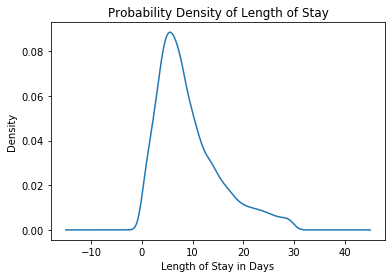

In [5]:
# Generate a binary target flagging whether an observation's length_of_stay value is above or below the mean. 
mean_val=df['length_of_stay'].mean()
df['long_los'] = df['length_of_stay'].apply(lambda x: 1 if x > mean_val else 0)
los_tbl = df[['length_of_stay', 'long_los']].describe().transpose().round(4)
display(los_tbl.style.applymap(helper.highlight_col, subset=pd.IndexSlice[:, 'mean']))

# Display LOS distributions
display(Markdown('---'))
ax = df['length_of_stay'].plot(kind='kde', title="Probability Density of Length of Stay")
ax.set_xlabel("Length of Stay in Days")
plt.show()

----
# Part 2 - Train Length of Stay Models

In [34]:
# Shared Functions
from sklearn.model_selection import train_test_split
import sklearn.metrics as sk_metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import dump

## Baseline - Random Sampling

In [9]:
import random

# generate "predictions" as random sample of target values
y_test = df['long_los']
pos_weight = y_test.mean()
weights = [1-pos_weight, pos_weight]
values = y_test.unique()
y_pred_baseline = np.array(random.choices(values, weights, k=df.shape[0]))
y_prob_baseline = y_pred_baseline

# display baseline performance 
print("\n", "Prediction Scores for Baseline Model:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_baseline, target_names=['LOS <= mean', 'LOS > mean']
                                      ).replace("LOS <=", bold_mgta+ "LOS <=").replace("LOS >", clr_off + "LOS >") )


 Prediction Scores for Baseline Model: 
               precision    recall  f1-score   support

 LOS <= mean       0.61      0.61      0.61     13730
  LOS > mean       0.39      0.39      0.39      8704

    accuracy                           0.53     22434
   macro avg       0.50      0.50      0.50     22434
weighted avg       0.53      0.53      0.53     22434



## Split Data for other Models

In [37]:
# Subset and Split Data
X = df.loc[:,[c for c in df.columns if c not in ['length_of_stay', 'long_los']]]
y = df.loc[:, ['long_los']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)



## Naive Bayes Classifier

In [38]:
from sklearn.naive_bayes import BernoulliNB

# Set model parameters (currently set as default values, but defined here to be explicit)
nb_params = {'alpha':1.0, 'binarize':0.0, 'fit_prior':True}

# Train Model
nb_model = BernoulliNB(**nb_params)
nb_model.fit(X_train, y_train.iloc[:,0])
y_pred_nb = nb_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_nb, target_names=['LOS <= mean', 'LOS > mean']
                                      ).replace("LOS <=", bold_mgta+ "LOS <=").replace("LOS >", clr_off + "LOS >") )


 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.78      0.81      0.79      4531
  LOS > mean       0.68      0.64      0.66      2873

    accuracy                           0.74      7404
   macro avg       0.73      0.73      0.73      7404
weighted avg       0.74      0.74      0.74      7404



## Decision Tree Model

In [44]:
from sklearn.tree import DecisionTreeClassifier

# Set model parameters (currently set as default values, but defined here to be explicit)
dt_params = {}

# Train Model
dt_model = DecisionTreeClassifier(**dt_params)
dt_model.fit(X_train, y_train.iloc[:,0])
y_pred_dt = dt_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_dt, target_names=['LOS <= mean', 'LOS > mean']
                                      ).replace("LOS <=", bold_mgta+ "LOS <=").replace("LOS >", clr_off + "LOS >") )


 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.73      0.74      0.73      4531
  LOS > mean       0.58      0.57      0.58      2873

    accuracy                           0.67      7404
   macro avg       0.66      0.65      0.66      7404
weighted avg       0.67      0.67      0.67      7404



## Random Forest Model

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Set model parameters (currently set as default values, but defined here to be explicit)
rf_params = {}

# Train Model
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train.iloc[:,0])
y_pred_rf = rf_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_rf, target_names=['LOS <= mean', 'LOS > mean']
                                      ).replace("LOS <=", bold_mgta+ "LOS <=").replace("LOS >", clr_off + "LOS >") )


 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.76      0.91      0.83      4531
  LOS > mean       0.79      0.54      0.64      2873

    accuracy                           0.77      7404
   macro avg       0.77      0.73      0.73      7404
weighted avg       0.77      0.77      0.75      7404



## Logit Regression Model

In [51]:
from sklearn.linear_model import LogisticRegression

# Set model parameters (currently set as default values, but defined here to be explicit)
lr_params = {'max_iter':10**4}

# Train Model
lr_model = LogisticRegression(**lr_params)
lr_model.fit(X_train, y_train.iloc[:,0])
y_pred_lr = lr_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_lr, zero_division=0, target_names=['LOS <= mean', 'LOS > mean']
                                      ).replace("LOS <=", bold_mgta+ "LOS <=").replace("LOS >", clr_off + "LOS >") )


 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.61      1.00      0.76      4531
  LOS > mean       0.00      0.00      0.00      2873

    accuracy                           0.61      7404
   macro avg       0.31      0.50      0.38      7404
weighted avg       0.37      0.61      0.46      7404



/Users/christineallen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM Model

In [52]:
from sklearn.svm import LinearSVC 

# Set model parameters (currently set as default values, but defined here to be explicit)
svm_params = {'max_iter':10**6}

# Train Model
svm_model = LinearSVC(**svm_params)
svm_model.fit(X_train, y_train.iloc[:,0])
y_pred_svm = svm_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_svm, target_names=['LOS <= mean', 'LOS > mean']
                                      ).replace("LOS <=", bold_mgta+ "LOS <=").replace("LOS >", clr_off + "LOS >") )


 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.61      1.00      0.76      4531
  LOS > mean       0.00      0.00      0.00      2873

    accuracy                           0.61      7404
   macro avg       0.31      0.50      0.38      7404
weighted avg       0.37      0.61      0.46      7404



/Users/christineallen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/christineallen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XGBOOST Model

In [48]:
from xgboost import XGBClassifier

# Train Model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train.iloc[:,0])
y_pred_xgb = xgb_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_xgb, target_names=['LOS <= mean', 'LOS > mean']
                                      ).replace("LOS <=", bold_mgta+ "LOS <=").replace("LOS >", clr_off + "LOS >") )



 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.76      0.90      0.82      4531
  LOS > mean       0.77      0.54      0.64      2873

    accuracy                           0.76      7404
   macro avg       0.76      0.72      0.73      7404
weighted avg       0.76      0.76      0.75      7404



In [49]:
# Set model parameters
xgb_params = {'colsample_bytree': 1.0, 'gamma': 2, 'learning_rate': 0.05, 'max_depth': 5, 
                'min_child_weight': 1,  'n_estimators': 600, 'subsample': 0.6}

# Train Model
xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train.iloc[:,0])
y_pred_xgb = xgb_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_xgb, target_names=['LOS <= mean', 'LOS > mean']
                                      ).replace("LOS <=", bold_mgta+ "LOS <=").replace("LOS >", clr_off + "LOS >") )



 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.79      0.88      0.83      4531
  LOS > mean       0.77      0.63      0.69      2873

    accuracy                           0.78      7404
   macro avg       0.78      0.76      0.76      7404
weighted avg       0.78      0.78      0.78      7404



# Save Model Packet

In [53]:
models = {'naive_bayes_model':nb_model, 'decision_tree_model':dt_model, 'random_forest_model':rf_model, 'logit_regression_model':lr_model, 'xgboost_model':xgb_model}
packet = model_comparison.fairCompare(test_data=X_test, target_data=y_test, models=models)
dump(packet, output_file)

['/Users/christineallen/data/fairness_and_bias/mimic_model_comparison/binary_classification.joblib']